In [24]:
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from math import pi,sin,cos,acos,asin
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import math
from ml_metrics import rmse,mae
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import minimize
from matplotlib.ticker import PercentFormatter
from scipy.optimize import fsolve
import matplotlib.ticker as ticker

In [25]:
def cosd(b):
    return cos(math.radians(b))
def sind(a):
    return sin(math.radians(a))
def tand(f):
    return tan(math.radians(f))
def acosd(d):
    return math.degrees(acos(d))
def asind(c):
    return math.degrees(asin(c))

In [26]:
df=pd.read_csv('DynamicLineRating_2019_2.csv')
df['UT_Time']= df.JulianTime.apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M'))
df['LocalTime'] = df['UT_Time'] + timedelta(hours = 7)


In [27]:
def day(LocalTime):
    return float(datetime.strftime(LocalTime,'%d'))
df['Day'] = df.LocalTime.apply(lambda x:(day(x)))

In [28]:
def month(LocalTime):
    #local_Time = UT_Time + timedelta(hours = 7)
    return float(datetime.strftime(LocalTime,'%m'))
df['Month'] = df.LocalTime.apply(lambda x:(month(x)))

In [69]:
def month_day(LocalTime):
    #local_Time = UT_Time + timedelta(hours = 7)
    return datetime.strftime(LocalTime,'%m/%d %H:%M')
df['MonthDay'] = df.LocalTime.apply(lambda x:(month_day(x)))

In [71]:
#print(df.MonthDay)

In [129]:
#fig=plt.figure(figsize=(18,6))
#plt.plot(time, temp_plot)
#plt.ylabel('oC')
#plt.xlabel('Day of Jan')
#plt.title('Air Temperature in January')
#plt.grid(True)
#plt.show()

# AMPACITY PLOT


In [29]:
def wind(x):
    if abs(205.46-x) <= 90:
        return abs(205.46-x)
    elif abs(205.46-x) > 90:
        return (abs(180-abs(205.46-x)))
    else:
        return 0
   
    

In [7]:
df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd=np.array(df.WindDirection[(df.Month.isin([m]))&(df['Day']<32)])


NameError: name 'm' is not defined

In [30]:
Ts = 100 # maximum allowable Temp
def Re(Ta,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    return Do*p*Wv/u

In [31]:
def Qc(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural
    
    if Wv <= 0.2:
        return max(q1,q2,q3)
    else:
        return max(q1,q2)

In [32]:
def Qr(Ta):
    Do=0.0309
    Ts=100
    e = 0.7# emissivity
    return 17.8*Do*e*(1/10**8)*((Ts+273)**4-(Ta+273)**4)

In [33]:
a = 0.9 # absorbsibility
Do = 0.0309 # Conductor diameter
def Qs(qs):
    return a*Do*qs

In [34]:
def R(Ta): 
    R_low = 0.0983/1609.344
    R_high = 0.117/1609.344
    T_low = 25
    T_high = 75
    Ts =100
    Tf =0.5*(Ts+Ta)
    return R_low + (R_high-R_low)*(Tf-T_low)/(T_high-T_low)+R_low

In [35]:
def Re_CI(Ta,Wv):
    Tf=0.5*(Ta+Ts)
    #Ts = 100 # maximum allowable Temp
    L=2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #lamda #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#muy #dynamic viscosity of air
    He = 10 # elevation
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#gamma#density of air
    return Do*g*Wv/m

In [36]:
def Re_CI(Ta,Wv):
    Tf=0.5*(Ta+Ts)
    #Ts = 100 # maximum allowable Temp
    L=2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #lamda #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#muy #dynamic viscosity of air
    He = 10 # elevation
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#gamma#density of air
    return Do*g*Wv/m

In [37]:
def Cf(Ta):
    Tf = 0.5*(Ts+Ta)
    M_s = 329*0.45359237/(1000*0.3048)
    M_a = 899*0.45359237/(1000*0.3048)
    M = 1228*0.45359237/(1000*0.3048)
    C_steel = 481*(1+10**(-4)*(Tf-20))
    C_alum = 897*(1+3.8*10**(-4)*(Tf-20))
    return (C_steel*M_s + C_alum*M_a)/M

In [38]:
def Nu_90(Ta,Wv):
    if (Re_CI(Ta,Wv)>=100) and (Re_CI(Ta,Wv)<2650):
        return 0.641*Re_CI(Ta,Wv)**0.471
    elif (Re_CI(Ta,Wv)>=2650) and (Re_CI(Ta,Wv)<50000):
        return 0.048*Re_CI(Ta,Wv)**0.8
    else:
        return 0

In [39]:
def Nu(Ta,Wv,Wd):
    if (Wd <=24 and Wd >0):
        return Nu_90(Ta,Wv)*(0.42+0.68*(sind(Wd))**1.08)
    if (Wd >24 and Wd <90):
        return Nu_90(Ta,Wv)*(0.42+0.58*(sind(Wd))**0.9)
    else:
        return 0


In [40]:
def Nu_nat(Ta,Wv,Wd):
    Do = 0.0309
    Tf = 0.5*(Ta+Ts)
    L = 2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#dynamic viscosity of air
    He =10 # elevation
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#density of air     
    Gr = Do**3*(Ts-Ta)*10/((Tf+273)*(m/g))
    Pr = Cf(Tf)*m/L
    if ((Gr*Pr)>10**(-1))and((Gr*Pr)<10**2):
        return 1.02*(Gr*Pr)**0.148
    elif ((Gr*Pr)>10**(2))and((Gr*Pr)<10**4):
        return 0.850*(Gr*Pr)**0.188
    elif ((Gr*Pr)>10**(4))and((Gr*Pr)<10**7):
        return 0.480*(Gr*Pr)**0.250
    elif ((Gr*Pr)>10**(7))and((Gr*Pr)<10**12):
        return 0.125*(Gr*Pr)**0.333
    else:
        return 0

In [41]:
def Qc_CI(Ta,Wv,Wd):
    Ts = 100 # maximum allowable Temp
    Do = 0.0309
    Tf = 0.5*(Ta+Ts)
    L = 2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#dynamic viscosity of air
    He =10 # elevation
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#density of air
    Pc_force = (Nu(Ta,Wv,Wd))*pi*L*(Ts-Ta)
    Pc_nat = Nu_nat(Ta,Wv,Wd)*pi*L*(Ts-Ta)
    #if Wv <=0.5:
      #  return Pc_nat
    #else:
    return max(Pc_force,Pc_nat)

In [42]:
def I_CI(Ta,qs,Wv,Wd):
    return math.sqrt((Qc_CI(Ta,Wv,Wd)+Qr(Ta)-Qs(qs))/R(Ta))

In [20]:
Ta_tol = np.array(df.Temp_ThHyg1_degC_avg) #ambientTemp
Wv_tol = np.array(df.WindSpeed_Anemo1_ms_avg) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_tol = np.array(df.GHI_ThPyra1_Wm2_avg) #solarIrradiance
df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd_tol=np.array(df.WindDirection)

In [23]:
amp_plot_tol =np.array([I_3E(Ta_tol[i], qs_tol[i], Wv_tol[i], Wd_tol[i]) for i in range(len(Ta_tol))])

In [26]:
dadg_tol = np.array(amp_plot_tol[(amp_plot_tol<=940)])
adg_tol = np.array(amp_plot_tol[(amp_plot_tol>940)])
sum_dadg = np.sum(dadg_tol) 
sum_overall = np.sum(amp_plot_tol[np.logical_not(np.isnan(amp_plot_tol))])
#print(len(adg),len(amp_plot),len(adg)/len(amp_plot),sum_dadg/sum_overall)
print(sum_overall*1/60*np.sqrt(3)*220/(10**3))

4344048.770209507


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [47]:
m = 6
n =7
time = np.array(df.LocalTime[(df.Month.isin([m]))&(df['Day']<32)])
Ta = np.array(df.Temp_ThHyg1_degC_avg[(df.Month.isin([m]))&(df['Day']<32)]) #ambientTemp
Wv = np.array(df.WindSpeed_Anemo1_ms_avg[(df.Month.isin([m]))&(df['Day']<32)]) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs = np.array(df.GHI_ThPyra1_Wm2_avg[(df.Month.isin([m]))&(df['Day']<32)]) #solarIrradiance
df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd=np.array(df.WindDirection[(df.Month.isin([m]))&(df['Day']<32)])


In [24]:
I_CI(25,1000,5,90)

426.63424894616384

In [20]:
def I_3E(Ta,qs,Wv,Wd):
    return math.sqrt((Qc(Ta,Wd,Wv)+Qr(Ta)-Qs(qs))/R(Ta))
#Time = np.array(df.LocalTime[(df['Month']==m)&(df['Day']<15)])

In [ ]:
amp_plot =np.array([I_3E(Ta[i], qs[i], Wv[i], Wd[i]) for i in range(len(Ta))])

In [ ]:
amp_plot_CI =np.array([I_CI(Ta[i], qs[i], Wv[i], Wd[i]) for i in range(len(Ta))])

In [28]:
Nu_plot = np.array([Nu(Ta[i], Wv[i], Wd[i]) for i in range(len(Wd))])

In [30]:
for (i, val) in enumerate(amp_plot):
    if (i==130020):
        print(i, val)
#420

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


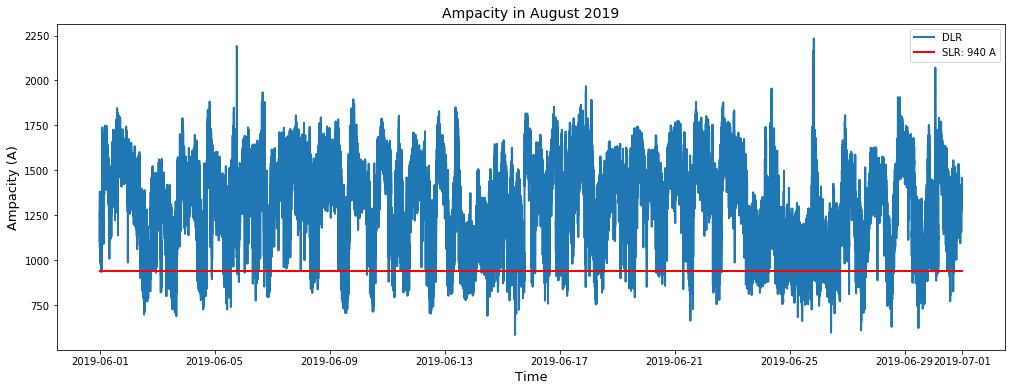

In [32]:
fig = plt.figure(figsize=(17,6))
plt.plot(time,amp_plot,linewidth=2,label ='DLR')
#plt.plot(Wv,[I_CI(25,1000,Wvi,90) for Wvi in Wv],color='blue',linewidth=3)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],color='green',linewidth=3)
#ax.set_xticks(range(0,11,1))
#ax.set_xticklabels(range(0,11,1))
yx = plt.subplot()
yx.set_yticks(range(250,2750,250))
yx.set_yticklabels(range(250,2750,250))
plt.ylabel('Ampacity (A)',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.title('Ampacity in August 2019',fontsize=14)
x = np.linspace(0,11,100)
y = [940 for i in time]
plt.plot(time,y,color='red',linewidth=2,label ='SLR: 940 A')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


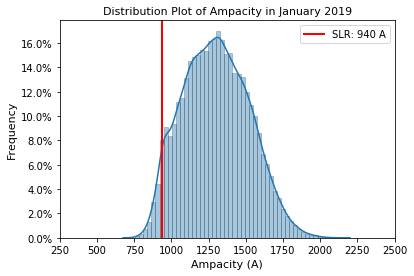

In [238]:
sns.distplot(amp_plot_np,bins=50,hist_kws=dict(edgecolor="black",linewidth=0.5))
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#locs, labels = xticks()
#plt.xticks(np.arange(300,2500,step=250))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Ampacity (A)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
plt.legend()
plt.title('Distribution Plot of Ampacity in January 2019',fontsize=11)
ax = plt.subplot()
ax.set_xticks(range(250,2750,250))
ax.set_xticklabels(range(250,2750,250))
#yx = plt.subplot()
#yx.set_yticks(range(0,18,2))
#yx.set_yticklabels(range(0,18,2))
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.01))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

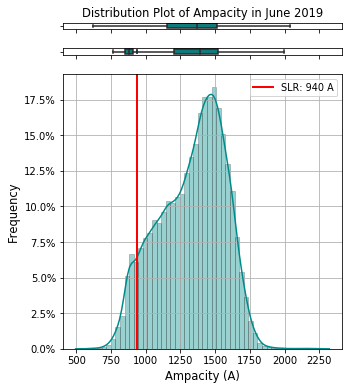

In [370]:
f, (ax_box, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.02,.02, .85)},figsize=(5,6))
sns.boxplot(amp_plot, color='darkcyan',ax=ax_box,showfliers=False)
#ax_box.scatter(1366.22,0,color='red')
sns.boxplot(dadg, color='darkcyan',ax=ax_box2,showfliers=False)
sns.boxplot(adg, color='darkcyan',ax=ax_box2,showfliers=False)
plt.grid()
#ax1 = plt.subplot()
ax_hist.set_xticks(range(250,2750,250))
ax_hist.set_xticklabels(range(250,2750,250))
sns.distplot(amp_plot,bins=50,ax=ax_hist,hist_kws=dict(edgecolor="black",linewidth=0.5),color='darkcyan')
plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')

plt.legend(loc='upper right',fontsize=9.65)
plt.xlabel('Ampacity (A)',fontsize=11.5)
plt.ylabel('Frequency',fontsize=11.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.01))
ax_box.set_title('Distribution Plot of Ampacity in June 2019',fontsize=11.5)
plt.show()

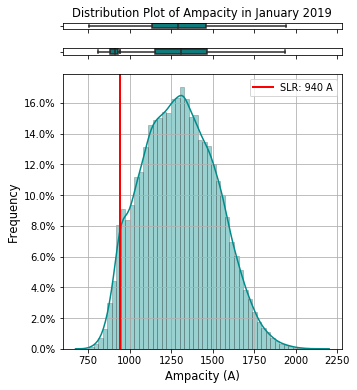

In [366]:
f, (ax_box, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.02,.02, .85)},figsize=(5,6))


sns.boxplot(amp_plot_np, color='darkcyan',ax=ax_box,showfliers=False)
#ax_box.set_xticks(range(250,2500,250))
#ax_box.set_xticklabels(range(250,2500,250))

sns.boxplot(dadg_np, color='darkcyan',ax=ax_box2,showfliers=False)
sns.boxplot(adg_np, color='darkcyan',ax=ax_box2,showfliers=False)
#ax_box2.set_xticks(range(250,2500,250))
#ax_box2.set_xticklabels(range(250,2500,250))
plt.grid()
#ax1 = plt.subplot()
ax_hist.set_xticks(range(250,2500,250))
ax_hist.set_xticklabels(range(250,2500,250))
sns.distplot(amp_plot_np,bins=50,ax=ax_hist,hist_kws=dict(edgecolor="black",linewidth=0.5),color='darkcyan')
plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#ax_hist.set_xticks(range(250,2500,250))
#ax_hist.set_xticklabels(range(250,2500,250))
plt.legend(loc='upper right',fontsize=9.65)
plt.xlabel('Ampacity (A)',fontsize=11.5)
plt.ylabel('Frequency',fontsize=11.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.01))
ax_box.set_title('Distribution Plot of Ampacity in January 2019',fontsize=11.5)
plt.show()

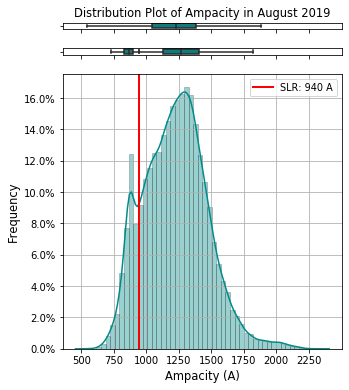

In [369]:
f, (ax_box, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.02,.02, .85)},figsize=(5,6))
sns.boxplot(amp_plot_8, color='darkcyan',ax=ax_box,showfliers=False)
#ax_box.scatter(1366.22,0,color='red')
sns.boxplot(dadg_8, color='darkcyan',ax=ax_box2,showfliers=False)
sns.boxplot(adg_8, color='darkcyan',ax=ax_box2,showfliers=False)
#ax1 = plt.subplot()
plt.grid()
ax_hist.set_xticks(range(250,2500,250))
ax_hist.set_xticklabels(range(250,2500,250))
sns.distplot(amp_plot_8,bins=50,ax=ax_hist,hist_kws=dict(edgecolor="black",linewidth=0.5),color='darkcyan')
plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#ax_hist.set_xticks(range(250,2500,250))
#ax_hist.set_xticklabels(range(250,2500,250))
plt.legend(loc='upper right',fontsize=9.65)
plt.xlabel('Ampacity (A)',fontsize=11.5)
plt.ylabel('Frequency',fontsize=11.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.01))
ax_box.set_title('Distribution Plot of Ampacity in August 2019',fontsize=11.5)
plt.show()

In [195]:
dadg = np.array(amp_plot[(amp_plot<=940)])
adg = np.array(amp_plot[(amp_plot>940)])
sum_dadg = np.sum(dadg) 
sum_overall = np.sum(amp_plot[np.logical_not(np.isnan(amp_plot))])
print(len(adg),len(amp_plot),len(adg)/len(amp_plot),sum_dadg/sum_overall)
#x[numpy.logical_not(numpy.isnan(x))]

40087 43200 0.9279398148148148 0.04731757971795114


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [191]:
dadg_np = np.array(amp_plot_np[(amp_plot_np<=940)])
adg_np = np.array(amp_plot_np[(amp_plot_np>940)])
sum_dadg_np = np.sum(dadg_np) 
sum_overall_np = np.sum(amp_plot_np[np.logical_not(np.isnan(amp_plot_np))])
print(len(dadg_np),len(amp_plot_np),len(dadg_np)/len(amp_plot_np),sum_dadg_np/sum_overall_np)
#x[numpy.logical_not(numpy.isnan(x))]

1903 44640 0.04262992831541219 0.029551715379520057


In [200]:
dadg_8 = np.array(amp_plot_8[(amp_plot_8<=940)])
adg_8 = np.array(amp_plot_8[(amp_plot_8>940)])
sum_dadg_8 = np.sum(dadg_8) 
sum_overall_8 = np.sum(amp_plot_8[np.logical_not(np.isnan(amp_plot_8))])
print(len(dadg_8),len(amp_plot_8),len(dadg_8)/len(amp_plot_8),sum_dadg_8/sum_overall_8)

6211 44640 0.13913530465949822 0.09757202144055675


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [401]:
sum_loss_np= np.sum(940- np.array(amp_plot_np[(amp_plot_np<=940)])) 
print(sum_loss_np*1/60*np.sqrt(3)*220/(10**3))
sum_gain_np = np.sum(np.array(amp_plot_np[(amp_plot_np>940)])-940)
print(sum_gain_np*1/60*np.sqrt(3)*220/(10**3))

477.2164654035485
102265.62315677897


In [396]:
sum_loss= np.sum(940- np.array(amp_plot[(amp_plot<=940)])) 
print(sum_loss*1/60*np.sqrt(3)*220/(10**3))
sum_gain = np.sum(np.array(amp_plot[(amp_plot>940)])-940)
print(sum_gain*1/60*np.sqrt(3)*220/(10**3))

1331.4514216821947
107927.48472992607


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [402]:
sum_loss_8= np.sum(940- np.array(amp_plot_8[(amp_plot_8<=940)])) 
print(sum_loss_8*1/60*np.sqrt(3)*220/(10**3))
sum_gain_8 = np.sum(np.array(amp_plot_8[(amp_plot_8>940)])-940)
print(sum_gain_8*1/60*np.sqrt(3)*220/(10**3))

3236.444794878265
83591.63304871408


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [405]:
sum_loss_tol= np.sum(940- np.array(amp_plot_tol[(amp_plot_tol<=940)])) 
print(sum_loss_tol*1/60*np.sqrt(3)*220/(10**3))
sum_gain_tol = np.sum(np.array(amp_plot_tol[(amp_plot_tol>940)])-940)
print(sum_gain_tol*1/60*np.sqrt(3)*220/(10**3))

16025.934727000898
1230477.7575995899


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [372]:
np.median(amp_plot_8[np.logical_not(np.isnan(amp_plot_8))])

1224.9265620531685

In [202]:
np.median(dadg_8)

868.7575437094669

In [204]:
np.median(adg_8)

1267.934332459804

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


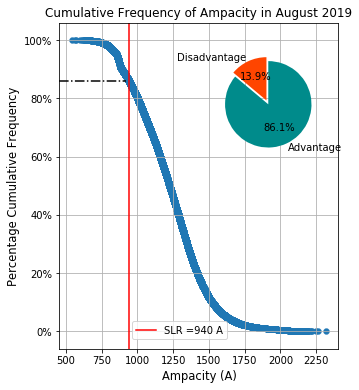

In [373]:
plt.figure(figsize=(5,6))
plt.axvline(x=940,color='red',label='SLR =940 A')
#plt.xticks(np.arange(250, 3000, step=250))
plt.legend(loc='upper right', bbox_to_anchor=(0.62, 0.1))
plt.xlabel('Ampacity (A)',fontsize=11.5)
plt.ylabel('Percentage Cumulative Frequency',fontsize=11.5)
plt.title('Cumulative Frequency of Ampacity in August 2019',fontsize=12)

x=np.sort(amp_plot_8)[::-1]
n=x.size
y = np.arange(1, n+1) / n
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.axhline(y=0.861, xmin=0, xmax=0.24,color='black',linestyle='dashdot')
plt.grid()
plt.scatter(x=x, y=y,linewidths=0.3)
ax1 = plt.subplot()
ax1.set_xticks(range(500,2450,250))
ax1.set_xticklabels(range(500,2450,250))
ax = plt.axes([0.55, 0.55, 0.3, 0.3])

ax.pie([13.9,86.1],colors=('orangered','darkcyan'),explode=(0, 0.1),startangle=90,autopct='%1.1f%%',labels=('Disadvantage','Advantage'))
#plt.pie()
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


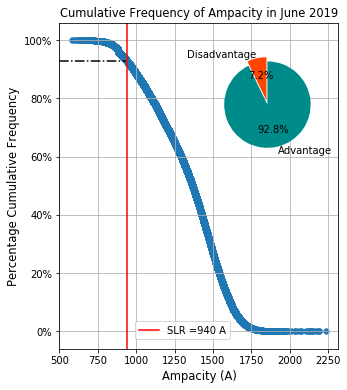

In [374]:
plt.figure(figsize=(5,6))
plt.axvline(x=940,color='red',label='SLR =940 A')
#plt.xticks(np.arange(250, 3000, step=250))
plt.legend(loc='upper right', bbox_to_anchor=(0.63, 0.1))
plt.xlabel('Ampacity (A)',fontsize=11.5)
plt.ylabel('Percentage Cumulative Frequency',fontsize=11.5)
plt.title('Cumulative Frequency of Ampacity in June 2019',fontsize=11.5)

x=np.sort(amp_plot)[::-1]
n=x.size
y = np.arange(1, n+1) / n
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.axhline(y=0.928, xmin=0, xmax=0.24,color='black',linestyle='dashdot')
plt.grid()
plt.scatter(x=x, y=y,linewidths=0.3)
ax1 = plt.subplot()
ax1.set_xticks(range(500,2450,250))
ax1.set_xticklabels(range(500,2450,250))
ax = plt.axes([0.55, 0.55, 0.3, 0.3])

ax.pie([7.2,92.8],colors=('orangered','darkcyan'),explode=(0, 0.1),startangle=90,autopct='%1.1f%%',labels=('Disadvantage','Advantage'))
#plt.pie()
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


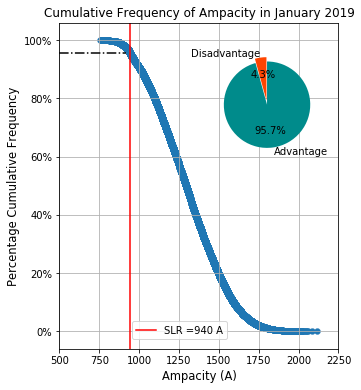

In [344]:
plt.figure(figsize=(5,6))
plt.axvline(x=940,color='red',label='SLR =940 A')
#plt.xticks(np.arange(250, 3000, step=250))
plt.legend(loc='upper right', bbox_to_anchor=(0.62, 0.1))
plt.xlabel('Ampacity (A)',fontsize=11.5)
plt.ylabel('Percentage Cumulative Frequency',fontsize=11.5)
plt.title('Cumulative Frequency of Ampacity in January 2019',fontsize=12)

x=np.sort(amp_plot_np)[::-1]
n=x.size
y = np.arange(1, n+1) / n
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.axhline(y=0.957, xmin=0, xmax=0.24,color='black',linestyle='dashdot')
plt.grid()
plt.scatter(x=x, y=y,linewidths=0.3)
ax1 = plt.subplot()
ax1.set_xticks(range(500,2450,250))
ax1.set_xticklabels(range(500,2450,250))
ax = plt.axes([0.55, 0.55, 0.3, 0.3])

ax.pie([4.3,95.7],colors=('orangered','darkcyan'),explode=(0, 0.1),startangle=90,autopct='%1.1f%%',labels=('Disadvantage','Advantage'))
#plt.pie()
plt.show()



In [43]:
def K_a(Wd):
    return 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd)

In [44]:
def eff_wind(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
#Do*p*Wv/u
    # Wv = # wind velocity
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural   
    
    if q1>q2:
        return (((K_a(Wd)*(1.01+1.35*(Re(Ta,Wv)**0.52))/K_a(90)-1.01)/1.35)**(1/0.52))*u/(Do*p)
    else:
        return ((K_a(Wd)*(Re(Ta,Wv)**0.6)/K_a(90))**(1/0.6))*u/(Do*p)

In [112]:
k=11
t=12
Ta_8 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==8)&(df['Day'].isin([11,12]))]) #ambientTemp
Wv_8 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==8)&(df['Day'].isin([11,12]))]) #windVelocity
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_8 = np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==8)&(df['Day'].isin([11,12]))]) #solarIrradiance

Te_8 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==8)&(df['Day'].isin([11,12]))]) #ambientTemp
Ve_8 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==8)&(df['Day'].isin([11,12]))])
De_8 =np.array(df.WindDirection[(df['Month']==8)&(df['Day'].isin([11,12]))])
Wve_8 = np.array([eff_wind(Te_8[i], De_8[i], Ve_8[i]) for i in range(len(Te_8))])

Wd_8=np.array(df.WindDirection[(df['Month']==8)&(df['Day'].isin([11,12]))])
time_8 = np.array(df.LocalTime[(df['Month']==8)&(df['Day'].isin([11,12]))])
amp_plot_8 =np.array([I_3E(Ta_8[i], qs_8[i], Wv_8[i], Wd_8[i]) for i in range(len(Ta_8))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


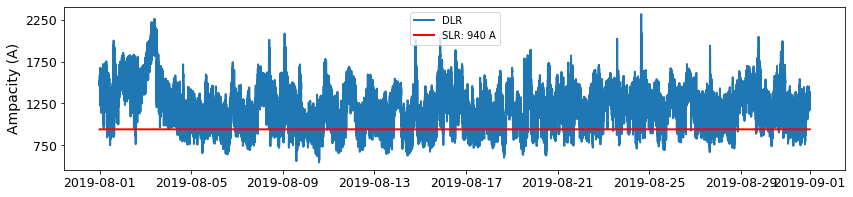

In [109]:
fig = plt.figure(figsize=(14,3))
plt.plot(time_8,amp_plot_8,linewidth=2,label ='DLR')
#plt.plot(Wv,[I_CI(25,1000,Wvi,90) for Wvi in Wv],color='blue',linewidth=3)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],color='green',linewidth=3)
#ax.set_xticks(range(0,11,1))
#ax.set_xticklabels(range(0,11,1))
yx = plt.subplot()
yx.set_yticks(range(250,2750,500))
yx.set_yticklabels(range(250,2750,500),fontsize=12.5)
plt.ylabel('Ampacity (A)',fontsize=14)
#plt.xlabel('Time',fontsize=11.5)
#plt.title('Ampacity in June 2019',fontsize=14)
x = np.linspace(0,11,100)
y = [940 for i in time_8]
plt.plot(time_8,y,color='red',linewidth=2,label ='SLR: 940 A')
#plt.xlabel('Time', fontsize=14)
plt.xticks(fontsize=12.5)
plt.legend()
plt.show()

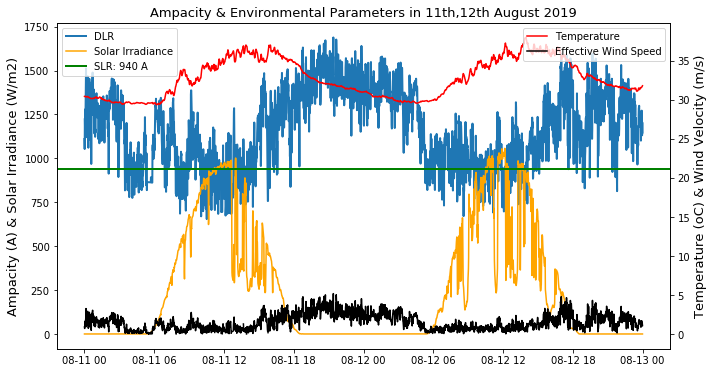

In [129]:
fig,ax = plt.subplots(figsize=(11,6))
ax.plot(time_8,amp_plot_8, linewidth=2,label='DLR')
ax.plot(time_8,qs_8, linewidth=1.5,label='Solar Irradiance',color='orange')
#ax.set_xlabel("Time",fontsize=13)
ax.set_ylabel("Ampacity (A) & Solar Irradiance (W/m2)",fontsize=13)
#ax.set_yticks(range(250,1750,250))
#ax.set_yticklabels(range(250,1750,250),fontsize=12.5)
plt.legend(loc='upper left',fontsize=12)
#x = np.linspace(0,11,100)
plt.axhline(y=940, color='green',linewidth=2,label='SLR: 940 A')
plt.legend(loc='upper left',fontsize=10)
ax2=ax.twinx()
ax2.plot(time_8,Ta_8,linewidth=1.5,color='red',label='Temperature')
ax2.plot(time_8,Wve_8,linewidth=1.5,color='black',label='Effective Wind Speed')
ax2.set_ylabel("Temperature (oC) & Wind Velocity (m/s)",fontsize=13)
plt.title('Ampacity & Environmental Parameters in 11th,12th August 2019',fontsize=13)
plt.xticks(fontsize=12.5)
plt.legend(loc='upper right',fontsize=10)
plt.show()

In [125]:
Ta_mp = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #ambientTemp
Wv_mp = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #windVelocity
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_mp = np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #solarIrradiance

Te = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #ambientTemp
Ve = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==6)&(df['Day'].isin([21,22]))])
De=np.array(df.WindDirection[(df['Month']==6)&(df['Day'].isin([21,22]))])
Wve_mp = np.array([eff_wind(Te[i], De[i], Ve[i]) for i in range(len(Te))])

Wd_mp=np.array(df.WindDirection[(df['Month']==6)&(df['Day'].isin([21,22]))])
time_mp = np.array(df.LocalTime[(df['Month']==6)&(df['Day'].isin([21,22]))])
amp_plot_mp =np.array([I_3E(Ta_mp[i], qs_mp[i], Wv_mp[i], Wd_mp[i]) for i in range(len(Ta_mp))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


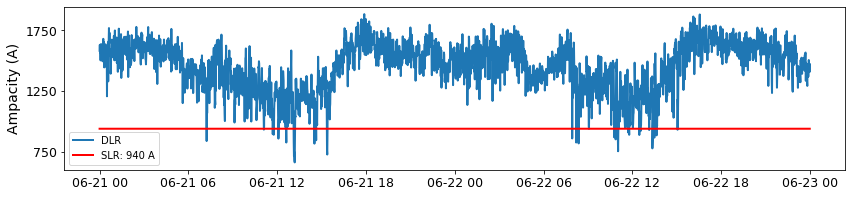

In [126]:
fig = plt.figure(figsize=(14,3))
plt.plot(time_mp,amp_plot_mp,linewidth=2,label ='DLR')
#plt.plot(Wv,[I_CI(25,1000,Wvi,90) for Wvi in Wv],color='blue',linewidth=3)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],color='green',linewidth=3)
#ax.set_xticks(range(0,11,1))
#ax.set_xticklabels(range(0,11,1))
yx = plt.subplot()
yx.set_yticks(range(250,2750,500))
yx.set_yticklabels(range(250,2750,500),fontsize=12.5)
plt.ylabel('Ampacity (A)',fontsize=14)
#plt.xlabel('Time',fontsize=11.5)
#plt.title('Ampacity in June 2019',fontsize=14)
x = np.linspace(0,11,100)
y = [940 for i in time_mp]
plt.plot(time_mp,y,color='red',linewidth=2,label ='SLR: 940 A')
#plt.xlabel('Time', fontsize=14)
plt.xticks(fontsize=12.5)
plt.legend()
plt.show()

In [74]:
print(len(Wve_mp),len(amp_plot_mp))

43200 43200


In [ ]:
42855 43199

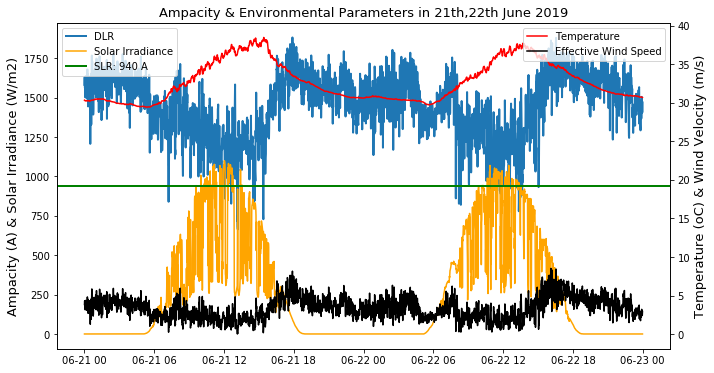

In [128]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(11,6))
# make a plot
ax.plot(time_mp,amp_plot_mp, linewidth=2,label='DLR')
ax.plot(time_mp,qs_mp, linewidth=1.5,label='Solar Irradiance',color='orange')
# set x-axis label
#ax.set_xlabel("Time",fontsize=13)
# set y-axis label
ax.set_ylabel("Ampacity (A) & Solar Irradiance (W/m2)",fontsize=13)
plt.legend(loc='upper left',fontsize=12)
#x = np.linspace(0,11,100)
# twin object for two different y-axis on the sample plot
plt.axhline(y=940, color='green',linewidth=2,label='SLR: 940 A')
plt.legend(loc='upper left',fontsize=10)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(time_mp,Ta_mp,linewidth=1.5,color='red',label='Temperature')
ax2.plot(time_mp,Wve_mp,linewidth=1.5,color='black',label='Effective Wind Speed')
#ax2.plot(time_mp,Wv_mp,linewidth=1.5,color='green',label='Wind Speed')
#ax2.plot(time_mp,Wd_mp,linewidth=1.5,color='green',label='wind relative angle')
ax2.set_ylabel("Temperature (oC) & Wind Velocity (m/s)",fontsize=13)
plt.title('Ampacity & Environmental Parameters in 21th,22th June 2019',fontsize=13)
plt.legend(loc='upper right',fontsize=10)
plt.show()


In [130]:
Ta_np = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==1)&(df['Day'].isin([21,22]))]) #ambientTemp
Wv_np = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==1)&(df['Day'].isin([21,22]))]) #windVelocity
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_np = np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==1)&(df['Day'].isin([21,22]))]) #solarIrradiance

Te_n = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==1)&(df['Day'].isin([21,22]))]) #ambientTemp
Ve_n = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==1)&(df['Day'].isin([21,22]))])
De_n =np.array(df.WindDirection[(df['Month']==1)&(df['Day'].isin([21,22]))])
Wve_np = np.array([eff_wind(Te_n[i], De_n[i], Ve_n[i]) for i in range(len(Te_n))])

Wd_np=np.array(df.WindDirection[(df['Month']==1)&(df['Day'].isin([21,22]))])
time_np = np.array(df.LocalTime[(df['Month']==1)&(df['Day'].isin([21,22]))])
amp_plot_np =np.array([I_3E(Ta_np[i], qs_np[i], Wv_np[i], Wd_np[i]) for i in range(len(Ta_np))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


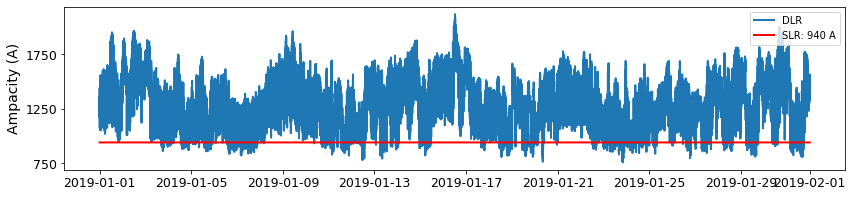

In [105]:
fig = plt.figure(figsize=(14,3))
plt.plot(time_np,amp_plot_np,linewidth=2,label ='DLR')
#plt.plot(Wv,[I_CI(25,1000,Wvi,90) for Wvi in Wv],color='blue',linewidth=3)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],color='green',linewidth=3)
#ax.set_xticks(range(0,11,1))
#ax.set_xticklabels(range(0,11,1))
yx = plt.subplot()
yx.set_yticks(range(250,2750,500))
yx.set_yticklabels(range(250,2750,500),fontsize=12.5)
plt.ylabel('Ampacity (A)',fontsize=14)
#plt.xlabel('Time',fontsize=11.5)
#plt.title('Ampacity in June 2019',fontsize=14)
x = np.linspace(0,11,100)
y = [940 for i in time_np]
plt.plot(time_np,y,color='red',linewidth=2,label ='SLR: 940 A')
#plt.xlabel('Time', fontsize=14)
plt.xticks(fontsize=12.5)
plt.legend()
plt.show()

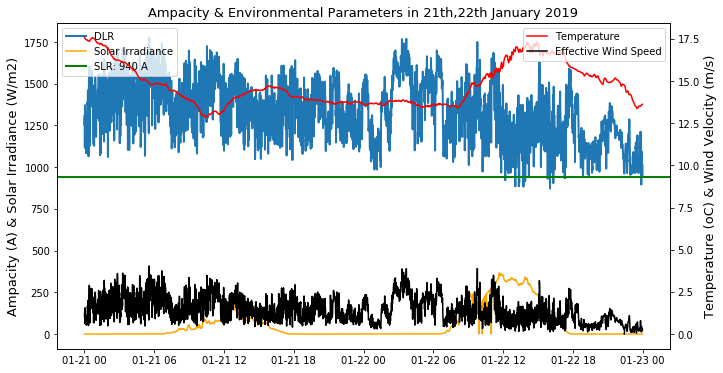

In [131]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(11,6))
# make a plot
ax.plot(time_np,amp_plot_np, linewidth=2,label='DLR')
ax.plot(time_np,qs_np, linewidth=1.5,label='Solar Irradiance',color='orange')
# set x-axis label
#ax.set_xlabel("Time",fontsize=13)
# set y-axis label
ax.set_ylabel("Ampacity (A) & Solar Irradiance (W/m2)",fontsize=13)
plt.legend(loc='upper left',fontsize=10)
plt.axhline(y=940, color='green',linewidth=2,label='SLR: 940 A')
plt.legend(loc='upper left',fontsize=10)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(time_np,Wd_np,linewidth=0.5,color='green',label='wind relative angle')
ax2.plot(time_np,Ta_np,linewidth=1.5,color='red',label='Temperature')
ax2.plot(time_np,Wve_np,linewidth=1.5,color='black',label='Effective Wind Speed')
#ax2.plot(time_np,Wv_np,linewidth=1.5,color='green',label='Wind Speed')
ax2.set_ylabel("Temperature (oC) & Wind Velocity (m/s)",fontsize=13)
plt.title('Ampacity & Environmental Parameters in 21th,22th January 2019',fontsize=13)
plt.legend(loc = 'upper right', fontsize=10)
plt.show()
# save the plot as a file
#fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#            format='jpeg',
#            dpi=100,
#            bbox_inches='tight')

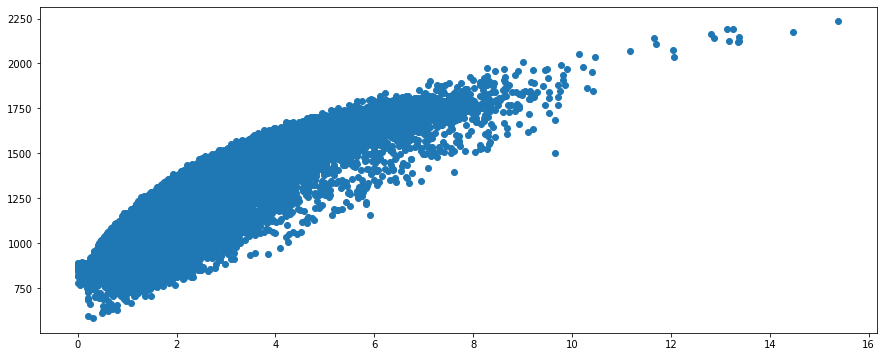

In [65]:
plt.figure(figsize=(15,6))
plt.scatter(Wv_mp,amp_plot_mp);

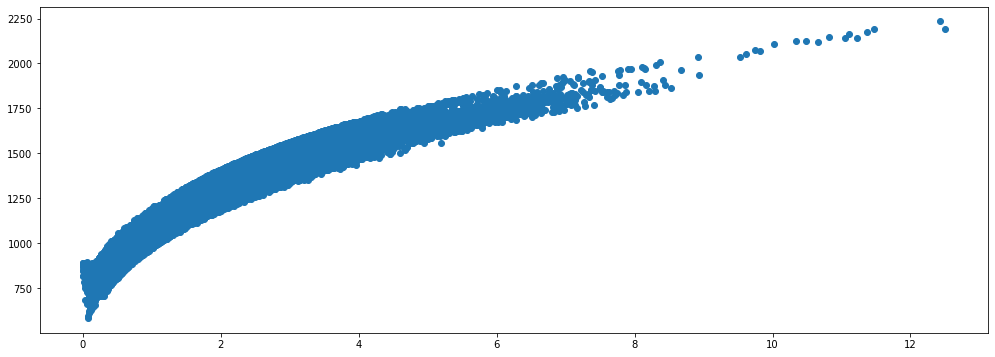

In [64]:
plt.figure(figsize=(17,6))
plt.scatter(Wve_mp,amp_plot_mp)

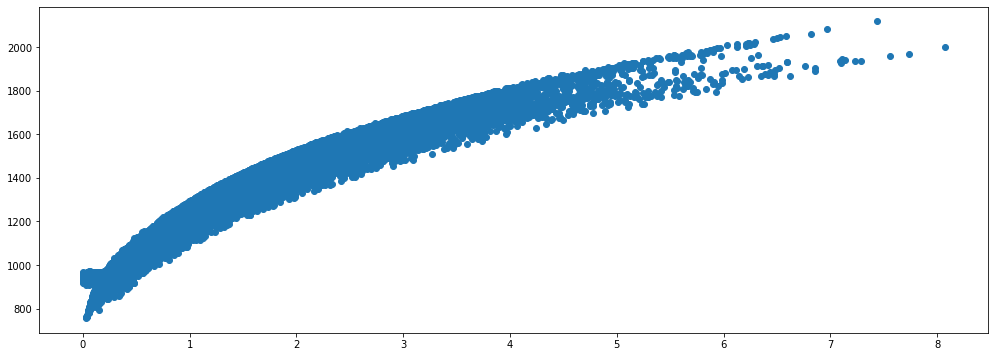

In [67]:

plt.figure(figsize=(17,6))
plt.scatter(Wve_np,amp_plot_np)

In [76]:
plt.figure(figsize=(17,6))
Wve_mp = Wve_mp[np.logical_not(np.isnan(Wve_mp)&np.isnan(amp_plot_mp))]
amp_plot_mp = amp_plot_mp[np.logical_not(np.isnan(amp_plot_mp))]

total_bins = 90
bins = np.linspace(Wve_mp.min(),amp_plot_mp.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(Wve_mp,bins)
running_median = [np.median(amp_plot_mp[idx==k]) for k in range(total_bins)]

plt.scatter(Wve_mp,amp_plot_mp)
#plt.scatter(X,Y,color='k',alpha=.2,s=2)
plt.plot(bins-delta/2,running_median)#,'r--',lw=4,alpha=.8)
#plt.axis('tight')
plt.show()

ValueError: operands could not be broadcast together with shapes (43199,) (43200,) 

<Figure size 1224x432 with 0 Axes>

In [72]:
print(len(Wve_mp),len(amp_plot_mp))

42855 43199


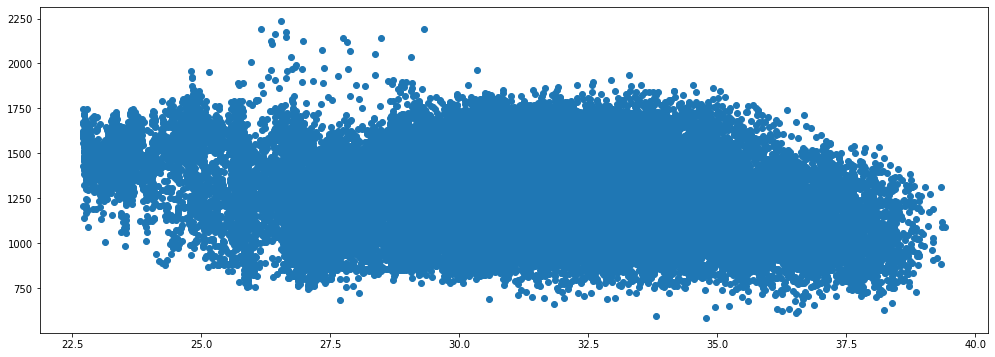

In [68]:
plt.figure(figsize=(17,6))
plt.scatter(Ta_mp,amp_plot_mp);

In [69]:
print(np.median(Ta_mp))

nan


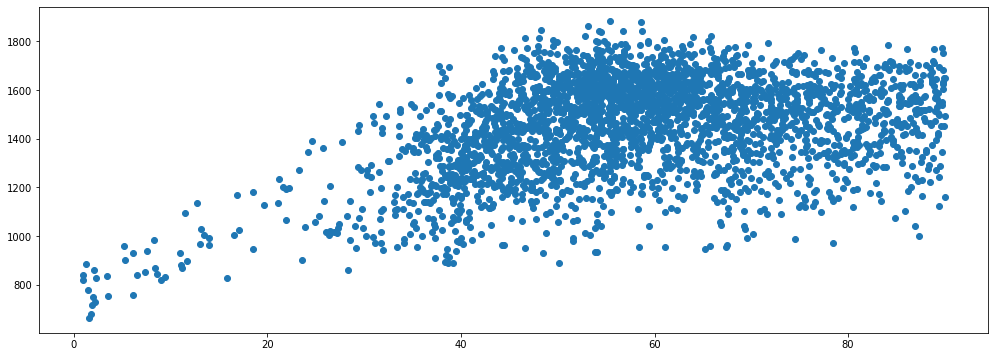

In [40]:
plt.figure(figsize=(17,6))
plt.scatter(Wd_mp,amp_plot_mp);

In [41]:
Ta_str = np.array(df.Temp_ThHyg1_degC_avg) #ambientTemp
Wv_str = np.array(df.WindSpeed_Anemo1_ms_avg) #windVelocity
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_str = np.array(df.GHI_ThPyra1_Wm2_avg) #solarIrradiance

T = np.array(df.Temp_ThHyg1_degC_avg) #ambientTemp
V = np.array(df.WindSpeed_Anemo1_ms_avg)
D=np.array(df.WindDirection)
We_str = np.array([eff_wind(T[i], D[i], V[i]) for i in range(len(T))])

Wd_str=np.array(df.WindDirection)
time_str = np.array(df.LocalTime)
amp_plot_str =np.array([I_3E(Ta_str[i], qs_str[i], Wv_str[i], Wd_str[i]) for i in range(len(Ta_str))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


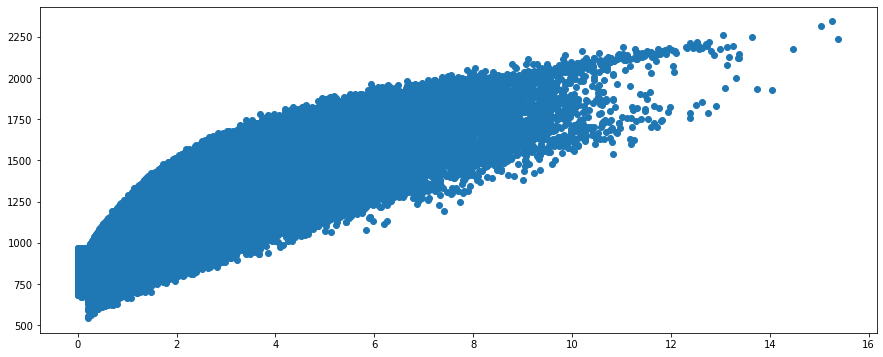

In [42]:
plt.figure(figsize=(15,6))
plt.scatter(Wv_str,amp_plot_str);

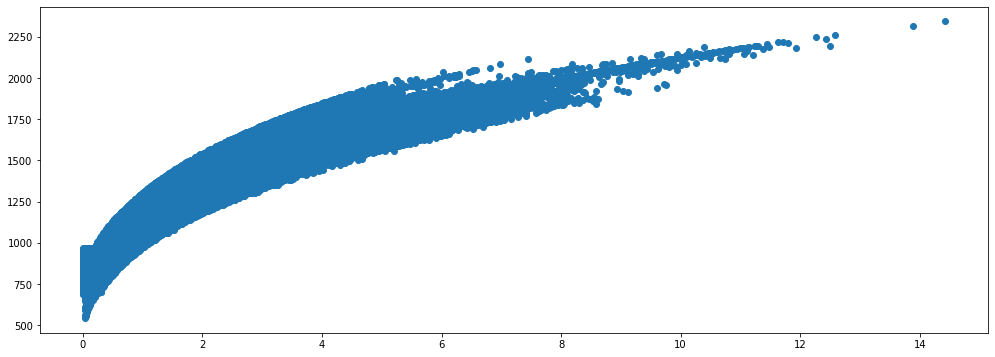

In [43]:
plt.figure(figsize=(17,6))
plt.scatter(We_str,amp_plot_str);

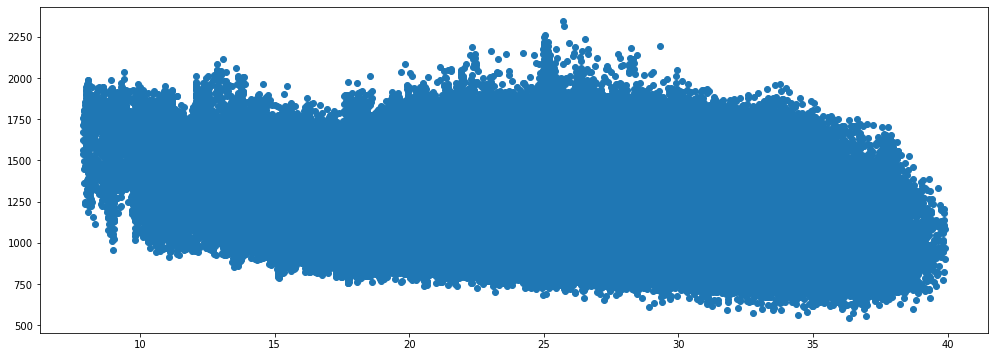

In [44]:
plt.figure(figsize=(17,6))
plt.scatter(Ta_str,amp_plot_str);

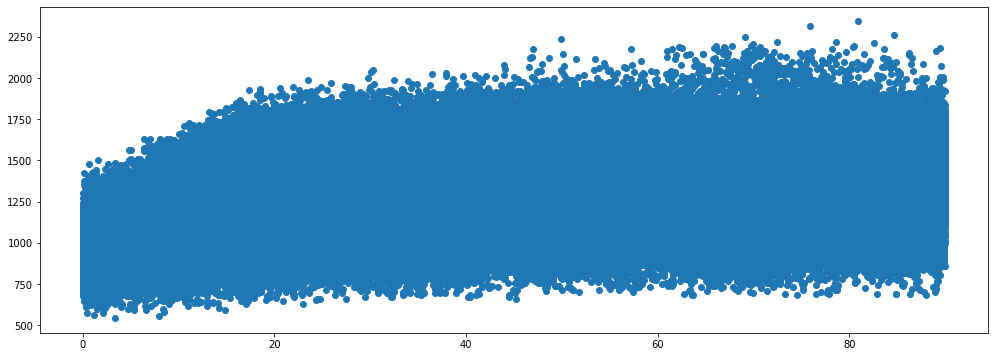

In [45]:
plt.figure(figsize=(17,6))
plt.scatter(Wd_str,amp_plot_str);

In [38]:
Wd_mp=np.array(df.WindDirection[(df['Month']==m)&(df['Day'].isin([21,22]))])
time_mp = np.array(df.LocalTime[(df['Month']==m)&(df['Day'].isin([21,22]))])

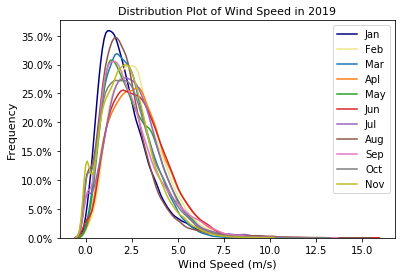

In [39]:
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==1)]),color='navy',label='Jan',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==2)]),color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==3)]),label='Mar',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==4)]),label='Apl',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==5)]),label='May',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==6)]),label='Jun',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==7)]),label='Jul',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==8)]),label='Aug',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==9)]),label='Sep',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==10)]),label='Oct',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==11)]),label='Nov',bins=50, hist=False)
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Wind Speed (m/s)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Wind Speed in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

In [40]:
T = np.array(df.Temp_ThHyg1_degC_avg) #ambientTemp
V = np.array(df.WindSpeed_Anemo1_ms_avg) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs = np.array(df.GHI_ThPyra1_Wm2_avg) #solarIrradiance
df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(wind)
D=np.array(df.WindDirection)

In [41]:
def Wv_ewp(T,D,V):
    return minimize(Qc_eff(T,90,V)-Qc_eff(T,D,V),[90],method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

In [42]:
print(Wv_ewp(25,80,V))

NameError: name 'Qc_eff' is not defined

In [43]:
def Qc_eff(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural
    
    return max(q1,q2,q3)

In [45]:
#Wd = np.array([(Wv_ewp(T[i],D[i],V),[90]) for i in range(len(D))])

In [40]:
amp= amp_plot_CI-amp_plot

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


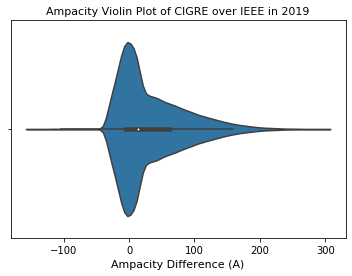

In [186]:
sns.violinplot(amp[(amp<300)&(amp>-150)])#,hist_kws=dict(edgecolor="black",linewidth=0.5))
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Ampacity Difference (A)',fontsize=11)
#plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Ampacity Violin Plot of CIGRE over IEEE in 2019',fontsize=11)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=0.1))
plt.show()